In [106]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import pandas as pd
import string
from typing import Optional

In [73]:
from navec import Navec
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [83]:
data = pd.read_csv('keyPhrases.csv', header=None)

In [84]:
data

,0
0,интеллектуальный капитал
1,оценка уровня интеллектуального капитала вуза
2,интеграционные объединения
3,гармонизация отношений
4,единое информационное пространство
...,...
1325,регионы
1326,стоимость предприятия
1327,проекты развития
1328,инновации


In [108]:
class PhraseEmbeddings:
    def __init__(self, phrase, embbedings):
        self.phrase: string = phrase
        self.embbedings: [float] = embbedings

def calculateEmbeddingsForSplittedPhrase(phrase: [string]) -> Optional[PhraseEmbeddings]:
    embeddings: [[]] = []
        
    for word in phrase:
        tempEmbedding = navec.get(word)

        if tempEmbedding is not None:
            embeddings.append(tempEmbedding)

    if len(embeddings) != 0:
        return PhraseEmbeddings(' '.join(phrase), embeddings)
    else:
        # return None -> if navec could not determine the embeddings of all words of the phrase.
        return None

In [141]:
e = calculateEmbeddingsForSplittedPhrase('интеллектуальный капитал')

In [143]:
e.embbedings[0]

array([-0.02038636, -0.4304574 , -0.31297466,  0.34323117,  0.14308096,
        0.00447617,  0.10517868, -0.01821613, -0.1296933 , -0.30858454,
        0.28430173,  0.02602685, -0.1070473 , -0.20268135,  0.04395203,
        0.21980411,  0.22511992,  0.09016208, -0.016583  , -0.03686598,
       -0.0653549 , -0.40943342,  0.2052517 ,  0.2360437 ,  0.04232125,
        0.20862643,  0.21483725,  0.68034965,  0.04575434,  0.0501943 ,
        0.10113248, -0.1415965 ,  0.7290677 ,  0.27665406,  0.08504464,
       -0.06380272, -0.10665073,  0.07883653,  0.16016194, -0.10770592,
       -0.12467895, -0.00377788,  0.06405913, -0.13345073, -0.20317075,
        0.12492766, -0.0730844 ,  0.15780582, -0.061593  , -0.21363382,
       -0.03520037, -0.31519416, -0.46981683,  0.18613097, -0.13061374,
        0.15144172, -0.05440714, -0.07308158,  0.26481044, -0.13791753,
        0.02916685, -0.22735387, -0.24164334, -0.04917087,  0.18061757,
        0.1460473 , -0.1886088 , -0.05005212, -0.02564061, -0.04

In [136]:
# Для каждой строки нужно вычислить эмбеддинги каждого из слов, а затем взять среднее значение
# z = np.mean([x, y], axis=0), где x и y - эмбеддинги отдельных слов

emb = []
for row in data[0]:
    emb.append(calculateEmbeddingsForSplittedPhrase(row))

In [140]:
len(emb[0].embbedings[0])

300

In [123]:
len(emb[1].embbedings)

41

In [3]:
np.random.seed(48)

In [61]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))


class KMean:
    def __init__(self, K=5, max_iters=100, plot_steps=False):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps

        # list of samples indices for each cluster
        self.clusters = [[] for _ in range(self.K)]
        # mean feature vector for each cluster
        self.centroinds = []

    def predict(self, X):
        self.X = X
        self.n_samples, self.n_feature = X.shape

        # initialize centroids
        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroinds = [self.X[idx] for idx in random_sample_idxs]
        # optimization
        for _ in range(self.max_iters):
            # update clusters
            self.clusters = self._create_clusters(self.centroinds)
            if self.plot_steps:
                self.plot()
            # update centroids
            centroids_old = self.centroinds
            self.centroinds = self._get_centroids(self.clusters)
            if plot_steps: self.plot()
            # check if converged
            if self._is_converged(centroids_old, self.centroinds):
                break
        # return cluster labels
        return self._get_cluster_labels(self.clusters)
#        return self.clusters

    def _get_cluster_labels(self, clusters):
        labels = np.zeros(self.n_samples, dtype='int16')
        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                labels[sample_idx] = cluster_idx
        return labels

    def _create_clusters(self, centroids):
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters

    def _closest_centroid(self, samples, centroids):
        distances = [euclidean_distance(samples, point) for point in centroids]
        closest_idx = np.argmin(distances)
        return closest_idx

    def _get_centroids(self, clusters):
        centroids = np.zeros((self.K, self.n_feature))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    def _is_converged(self, centroids_old, centroids):
        distances = [euclidean_distance(centroids_old[i], centroids[i]) for i in range(self.K)]
        return sum(distances) == 0

    def plot(self):
        fig, ax = plt.subplots(figsize=(12, 8))

        for i, index in enumerate(self.clusters):
            point = self.X[index].T
            ax.scatter(*point)

        for point in self.centroinds:
            ax.scatter(*point, marker="x", color="black", linewidths=2)

        plt.show()

In [77]:
# n_samples = 1330, n_features = 300 

X, y = make_blobs(centers=3, n_samples=500, n_features=2, shuffle=True, random_state=48)
print(X.shape)

(500, 2)


In [7]:
clusters = len(np.unique(y))
print(clusters)

3


In [62]:
y_pred = KMean(K=3).predict(X, plot_steps=True)

In [78]:
s = []
k_max = 10

for k in tqdm(range(2,k_max+1)):
    y_pred = KMean(k).predict(X)
    s1 = silhouette_score(X, y_pred)
    s.append(s1)
    
print(s)

100%|██████████| 9/9 [00:10<00:00,  1.18s/it]

[0.5809748931527899, 0.832283391882073, 0.6466906943768931, 0.4673581326685428, 0.4670502061333426, 0.4761636965924591, 0.4814464117544181, 0.3265589986567321, 0.3012162826983847]


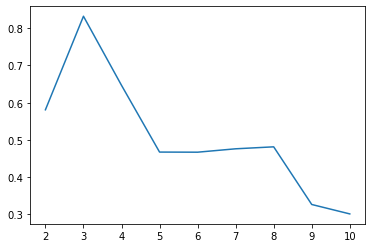

In [79]:
plt.plot(range(2,k_max+1), s)